# Weighted Linear Regression

CBE 20258. Numerical and Statistical Analysis. Spring 2020.

&#169; University of Notre Dame

In [1]:
# load libraries
import scipy.stats as stats
import numpy as np
import scipy.optimize as optimize
import math
import matplotlib.pyplot as plt

## Learning Objectives

After studying this notebook and your lecture notes, you should be able to:
* Apply weighted linear regression to correct for distortions with transformations

## Weighted Regression

### Michaelis-Menten Modeling Revisited

The **Michaelis-Menten** equation is an extremely popular model to describe the rate of enzymatic reactions.

$$
\mathrm{E} + \mathrm{S} \leftrightharpoons \mathrm{ES} \rightarrow \mathrm{E} + \mathrm{P}
$$

$$
r = V_{max} \frac{[\mathrm{S}]}{K_M + [\mathrm{S}]}
$$

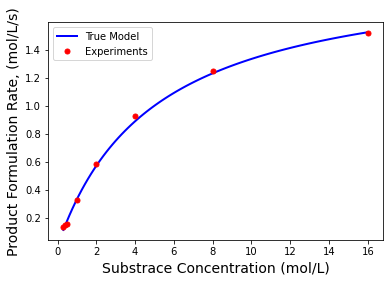

In [4]:
## Let's plot the model

# Define exact coefficients
Vmaxexact=2;
Kmexact=5;

# Evaluate model
Sexp = np.array([.3, .4, 0.5, 1, 2, 4, 8, 16]);
rexp = Vmaxexact*Sexp / (Kmexact+Sexp);

# Add some random error to simulate 
rexp += 0.05*np.random.normal(size=len(Sexp))

# Evaluate model to plot smooth curve
S = np.linspace(np.min(Sexp),np.max(Sexp),100)
r = Vmaxexact*S / (Kmexact+S)

plt.plot(S,r,'b-',linewidth=2,label="True Model")
plt.plot(Sexp,rexp,'r.',markersize=10,label="Experiments")
plt.xlabel('Substrace Concentration (mol/L)',fontsize=14)
plt.ylabel('Product Formulation Rate, (mol/L/s)',fontsize=14)
plt.legend()
plt.show()

### Approach 1: Transformation + Linear Regression

#### Step 1: Calculate Best Fit and Plot

In [6]:
y = 1/rexp
x = 1/Sexp

b1_, b0_, r_value, p_value, std_err = stats.linregress(x, y)

print("slope = ",b1_,"add units")
print("intercept =",b0_,"add units")

print(" ")
Vmax_lin = 1/b0_
Km_lin = b1_ / b0_
print("Vmax = ",Vmax_lin)
print("Km = ",Km_lin)

slope =  2.281673118056757 add units
intercept = 0.6967654354496964 add units
 
Vmax =  1.43520322496278
Km =  3.2746646173459393


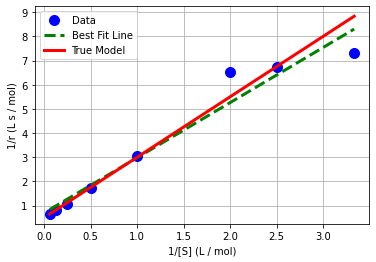

In [8]:
# generate predictions
x_pred = np.linspace(np.min(x),np.max(x),1000)
y_pred = b0_ + b1_ * x_pred

# create plot
plt.plot(x,y,'.b',markersize=20,label='Data')
plt.plot(x_pred,y_pred,'--g',linewidth=3,label='Best Fit Line')
plt.plot(1/S,1/r,'r-',linewidth=3,label='True Model')
plt.xlabel('1/[S] (L / mol)')
plt.ylabel('1/r (L s / mol)')
plt.grid(True)
plt.legend()
plt.show()

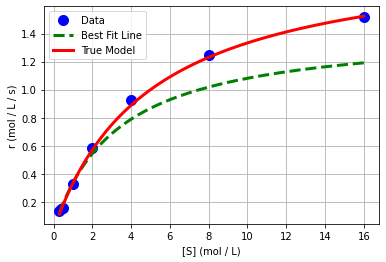

In [10]:
# create plot
plt.plot(Sexp,rexp,'.b',markersize=20,label='Data')
plt.plot(1/x_pred,1/y_pred,'--g',linewidth=3,label='Best Fit Line')
plt.plot(S,r,'r-',linewidth=3,label='True Model')
plt.xlabel('[S] (mol / L)')
plt.ylabel('r (mol / L / s)')
plt.grid(True)
plt.legend()
plt.show()

#### Step 2. Residual Analysis

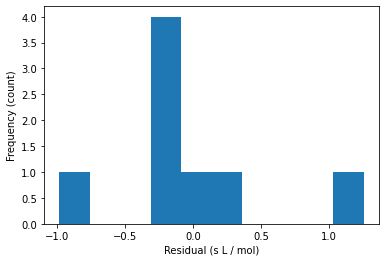

In [11]:
# Calculate residuals
y_hat = b0_ + b1_ * x
e = y - y_hat

# plot histogram of residuals
plt.hist(e)
plt.xlabel("Residual (s L / mol)")
plt.ylabel("Frequency (count)")
plt.show()

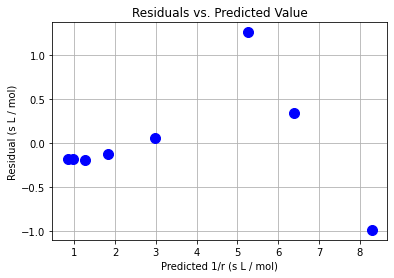

In [13]:
# scatter plot of residuals
plt.plot(y_hat,e,"b.",markersize=20)
plt.xlabel("Predicted 1/r (s L / mol)")
plt.ylabel("Residual (s L / mol)")
plt.grid(True)
plt.title("Residuals vs. Predicted Value")
plt.show()

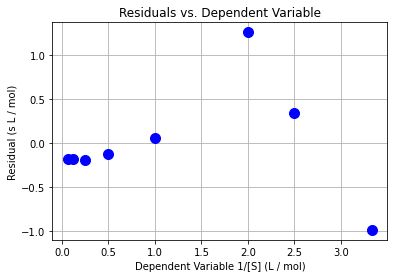

In [16]:
# another scatter plot
plt.plot(x,e,"b.",markersize=20)
plt.xlabel("Dependent Variable 1/[S] (L / mol)")
plt.ylabel("Residual (s L / mol)")
plt.grid(True)
plt.title("Residuals vs. Dependent Variable")
plt.show()

### Approach 2: Nonlinear Regression

See notes from previous Chap 13 notebooks.

### Approach 3: Transformation + Weighted Linear Regression

**Main Idea** Weight data points with greater uncertainty less.

$$
\min_{\hat{\beta}} \quad (y - X \hat{\beta})^T ~W~ (y - X \hat{\beta})
$$

What to use for the weight matrix $W$?

Let's assume each $r_{obs}$ measurement (i.e., observation) has uncertainty $\epsilon$:

$r_{obs} = r_{true} + \epsilon$

where var($\epsilon$) = $\sigma^2$. What is the uncertainty in $1/r_{obs}$?

**Short Activity**: Determine var($1/r_{obs}$) with a partner.

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: With a partner, compute var($1/r_{obs}$). Assume $\epsilon$ is a random variable.
</div>

#### Step 1: Calculate Best Fit and Plot

Let's further assume each observation uncertainty is independent. We will weight the regression problem with matrix $W$, which is proportional to the inverse of the covariance matrix:

$$
W = \begin{bmatrix}r_{1}^4 & 0 & \dots & 0 \\
0 & r_{2}^4 & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \dots & r_{n}^4
\end{bmatrix}
$$

The solution to the optimization problem above is easily calculated with linear algebra:

$$
(X^T W X) \hat{\beta} = X^T W y
$$

or

$$
\hat{\beta} = (X^T W X)^{-1} X^T W y
$$

Some textbooks define $K = (X^T W X)^{-1}$ to simply the above expressions. Let's apply this to our problem.

In [17]:
# diagonal elements
print(rexp**4)

[3.48783106e-04 4.84438327e-04 5.54209704e-04 1.16840027e-02
 1.16373801e-01 7.40959800e-01 2.42058847e+00 5.29439481e+00]


In [18]:
# create a diagonal matrix
W = np.diag(rexp**4)
print("W =\n",W)

W =
 [[3.48783106e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.84438327e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.54209704e-04 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.16840027e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.16373801e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 7.40959800e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 2.42058847e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 5.29439481e

In [24]:
# recall the transformation
y = 1/rexp
x = 1/Sexp

# construct the feature matrix
n = len(x)
Xmm = np.ones((n,2))

# first column - all ones
# second column - 1/r
Xmm[:,1] = x

# calculate inverse of XT * X
XXinv = np.linalg.inv(Xmm.transpose() @ W @ Xmm)
print("K = inv(XT W X) =\n",XXinv)

K = inv(XT W X) =
 [[ 0.29055436 -1.67534878]
 [-1.67534878 16.12382537]]


In [25]:
# calculate beta_hat
beta_hat_w = K @ Xmm.transpose() @ W @ y

print("beta_hat_w = \n",beta_hat_w)

beta_hat_w = 
 [0.50814018 2.36661941]


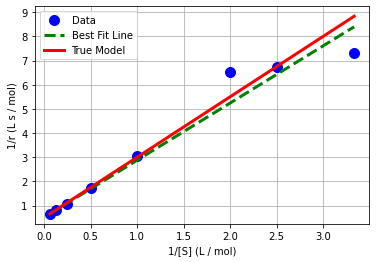

In [26]:
# generate predictions
x_pred = np.linspace(np.min(x),np.max(x),1000)
X_pred = np.ones((len(x_pred),2))
X_pred[:,1] = x_pred
y_pred = X_pred @ beta_hat_w

# create plot
plt.plot(x,y,'.b',markersize=20,label='Data')
plt.plot(x_pred,y_pred,'--g',linewidth=3,label='Best Fit Line')
plt.plot(1/S,1/r,'r-',linewidth=3,label='True Model')
plt.xlabel('1/[S] (L / mol)')
plt.ylabel('1/r (L s / mol)')
plt.grid(True)
plt.legend()
plt.show()

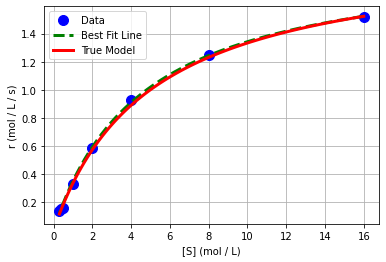

In [27]:
# create plot
plt.plot(Sexp,rexp,'.b',markersize=20,label='Data')
plt.plot(1/x_pred,1/y_pred,'--g',linewidth=3,label='Best Fit Line')
plt.plot(S,r,'r-',linewidth=3,label='True Model')
plt.xlabel('[S] (mol / L)')
plt.ylabel('r (mol / L / s)')
plt.grid(True)
plt.legend()
plt.show()

#### Step 2. Residual Analysis

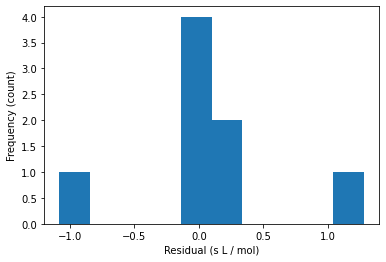

In [28]:
# Calculate residuals
y_hat = Xmm @ beta_hat_w
e = y - y_hat

# plot histogram of residuals
plt.hist(e)
plt.xlabel("Residual (s L / mol)")
plt.ylabel("Frequency (count)")
plt.show()

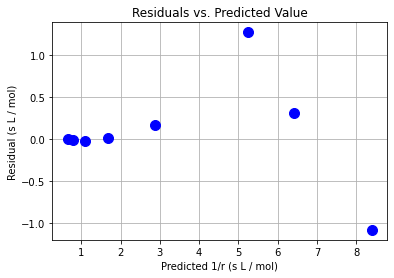

In [29]:
# scatter plot of residuals
plt.plot(y_hat,e,"b.",markersize=20)
plt.xlabel("Predicted 1/r (s L / mol)")
plt.ylabel("Residual (s L / mol)")
plt.grid(True)
plt.title("Residuals vs. Predicted Value")
plt.show()

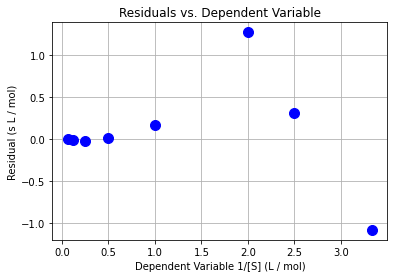

In [30]:
# another scatter plot
plt.plot(x,e,"b.",markersize=20)
plt.xlabel("Dependent Variable 1/[S] (L / mol)")
plt.ylabel("Residual (s L / mol)")
plt.grid(True)
plt.title("Residuals vs. Dependent Variable")
plt.show()

### Uncertainty Analysis

We also need to incorporate the weight matrix into our uncertainty analysis:

$$
\Sigma_{\beta} = K X^T W \Sigma_{e} W^T X K
$$

where $\Sigma_{e}$ is the covariance matrix of the residuals. We often assume $\Sigma_{e} = \hat{\sigma}_{e}^2 I$ where $I$ is an identity matrix.

In [31]:
# calculate variance of residuals
sigre = e @ e / (n-2)
print("Variance of residuals =",sigre)

Variance of residuals = 0.4870137752209181


In [32]:
# calculate covariance of fitted coefficients
cov_beta = K @ Xmm.transpose() * sigre @ W.transpose() @ Xmm @ K
print("covariance matrix:\n",cov_beta)

covariance matrix:
 [[ 0.14150398 -0.81591793]
 [-0.81591793  7.85252507]]
